# Parte 2  Turbidez en el agua

Para este apartado se va a estudiar la turbidez del agua. Para ello se ha escogido como fenómeno clave la pandemia, se van a seleccionar imágenes tomadas antes durante y después del confinamiento y visualizar como este acontecimiento incidió en la turbidez del agua.

Se repite el mismo código que se uso en la parte 1 para acceder a las imágenes ya que se necesitan imágenes en RGB y en falso color con infrarrojo cercano.

In [83]:
# Se importan las librerías necesarias para el trabajo
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import getpass
from pathlib import Path
from typing import Any, Optional, Tuple
import cv2 as cv
import math
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)
config = SHConfig('Teledeteccion') 

In [84]:
# coordenadas de Venecia
aoi_coords_wgs84 = aoi_coords_wgs84 = [12.27, 45.395, 12.39, 45.485] # Indicamos las coordenadas de longitudes y latitudes de las esquinas de la zona
resolution = 10                                            # Resolución en metros
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84) # Se crea el BBOX para formalizar las coordenadas
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution) # Cálculo del tamaño de la caja

In [ ]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3,
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""


evalscript_false_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B08", "B04", "B03"]
            }],
            output: {
                bands: 3,
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B08, sample.B04, sample.B03];
    }
    
"""

In [86]:
def devuelve_imagen(fechas):
    # Se indica que se quieren acceder a imagenes de sentinel 2 L2A
    request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                # Nombre del satélite y url de copernucus
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            # Intervalo de fechas
            time_interval= fechas,
            # se quiere con la menor cantidad de cobertura de nubes posibles
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,)
    
    request_false_color = SentinelHubRequest(
    evalscript=evalscript_false_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=fechas,
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,)
    true_color_imgs = request_true_color.get_data()
    false_color_imgs = request_false_color.get_data()
    res1 = true_color_imgs[0]
    res2 = false_color_imgs[0]
    return res1,res2

Aquí se cambian las fechas, y se indican como fechas un año antes de la pandemia, durante el confinamiento, después del confinamiento (dos meses después) , un año después y dos años después.

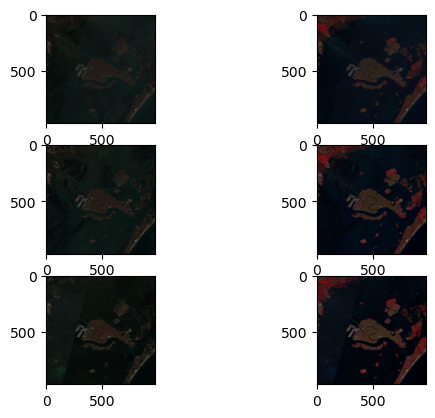

In [87]:
fechas = [('2019-03-01', '2019-03-15'), ('2020-04-01', '2020-04-15'),('2020-08-01', '2020-08-15'),('2021-03-01', '2021-03-15'), ('2022-03-01', '2022-03-15')]
ls_mesaño = ['2019-03', '2020-04', '2020-08', '2021-03', '2022-03']
def obten_imágenes(ds):
    ls_tc = []
    ls_fc = []
    for d in ds:
        im1, im2=devuelve_imagen(d)
        ls_tc.append(im1)
        ls_fc.append(im2)
    return ls_tc, ls_fc
# Se muestran las 3 primeras imágenes 
ls_tc, ls_fc= obten_imágenes(fechas)
fig, axs = plt.subplots(3, 2)
axs[0,0].imshow(ls_tc[0])
axs[0,1].imshow(ls_fc[0])
axs[1,0].imshow(ls_tc[1])
axs[1,1].imshow(ls_fc[1])
axs[2,0].imshow(ls_tc[2])
axs[2,1].imshow(ls_fc[2])

Le volvemos aplicar la técnica de expansión para aumentarle el brillo a la imagen (necesario para los índices).

In [88]:
def histograma(img):
    # Convierte en array de numpy
    np_image = np.array(img)
    # El eje x será los valores de los pixeles, el eje y será el conteo
    # se saca con np.unique
    x, y = np.unique(np_image, return_counts = True)
    #plt.bar(x,y)
    #plt.xlabel("Intensidades de pixeles")
    #plt.ylabel("Conteo")
    # devolvemos los distintos valores de pixeles y el contador
    return x,y
def expan(img,cmin,cmax):
    resimg = img.copy()
    np_array = np.array(resimg)
    mask1 = np_array <=cmin
    mask2 = np_array >=cmax
    mask3 = ~(mask1 | mask2)
    np_array[mask1] = 0.0
    np_array[mask2] = 255.0
    np_array[mask3] = 0.0 + (np_array[mask3] - cmin) * (255.0 / (cmax- cmin))
    return np_array.astype(np.uint8)

def corte(img,porc):
    img1 = img.copy() 
    # cálculo del histograma
    nd, frec = histograma(img1)
    total = sum(frec)
    # calculo de la proporción de pixeles que se van
    prop = int(total * porc)
    frecac = 0
    cmin = 0
    cmax = 0 
    # Recorremos las dos listas de pixeles y frecuencia 
    # calculamos la prefuencia acumulada 
    # el primer pixel cuya frecuencia acumulada revase a prop
    for i,j in zip(nd,frec):
        frecac += j
        if frecac > prop :
            cmin = i 
            break
    # lo mismo para cmax pero revertemos la lista
    frecac = 0
    for i,j in list(zip(nd,frec))[::-1]:
        frecac += j
        if frecac > prop :
            cmax = i 
            break
    return expan(img1,cmin,cmax)

Imágenes tras aplicar expansión


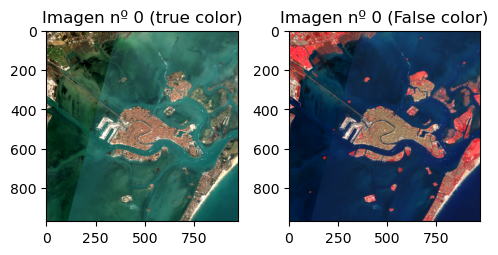

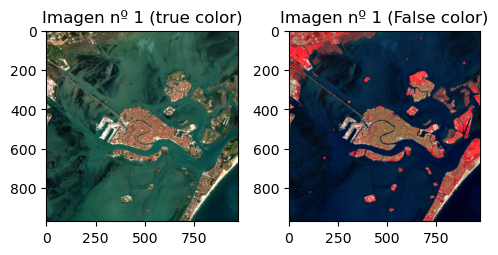

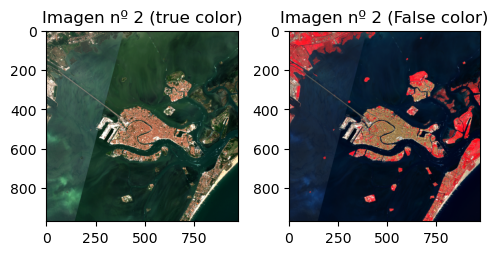

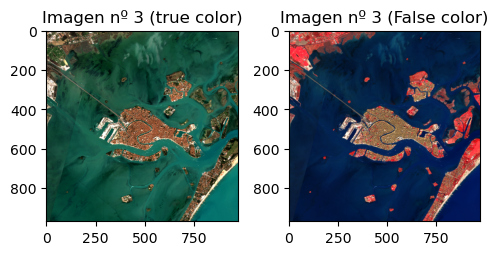

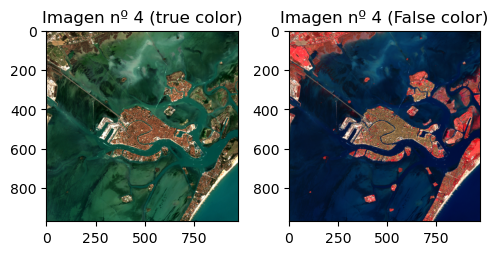

In [89]:
#Lista para las imágenes rgb
ls_tc_2 =[]
#Lista para las imágenes a falso color
ls_fc_2 =[]
print("Imágenes tras aplicar expansión")
for ind,(i_t, i_f) in enumerate(zip(ls_tc, ls_fc)):
    # le aplicamos un porcentaje de pixeles del 1%
    i_t_c = corte(i_t,0.01)
    # se añade a la lista
    ls_tc_2.append(i_t_c)
    i_f_c = corte(i_f,0.01)
    # se almacena a la lisat
    ls_fc_2.append(i_f_c)
    # Visualizamos las imágenes
    fig,ax = plt.subplots(1,2, figsize=(5, 6))
    ax[0].imshow(i_t_c)
    ax[0].set_title(f'Imagen nº {ind} (true color)')
    ax[1].imshow(i_f_c)
    ax[1].set_title(f'Imagen nº {ind} (False color)')
    # Para evitar solapamiento de los títulos
    plt.tight_layout()
    plt.show()

Se reutiliza el cálculo del índice NDWI que será usado posteriormente.

In [90]:
def ndwi(img_falsa,img_verdad):
     # Se le pasan dos imágenes, la imagen a verdadero color y a falso color
    # Extraemos la banda infrarojo, la tercera banda, que es el primer canal  
    imnir = img_falsa[:,:,0].astype(np.float64)
    # Extraemos la banda  verde,  B03
    imverd = img_verdad[:,:,1].astype(np.float64)
    # Creamos una nueva imagen con valor iniciado -1, para darle luego un valor de 0 en el rescalado a la imagen donde el 
    # divisor sea 0, para las zonas donde no hay agua
    img_res = np.full_like(imverd, -1)
    # Calculo del numerador
    numer = imverd- imnir
    denom = imverd + imnir
    # cuanod el denominador sea distinto de 0, para eviatar probelemas con la división
    filtro = denom != 0 
    img_res[filtro] = numer[filtro] / denom[filtro]
    # rescalado de la imagen 
    nvi = ((img_res +1)/2) *255
    return nvi.astype(np.uint8)

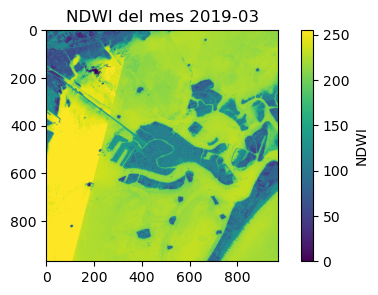

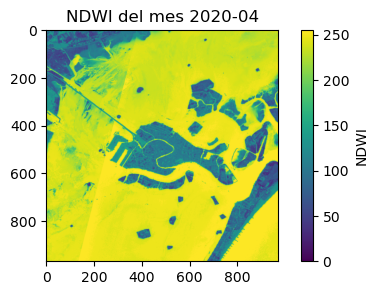

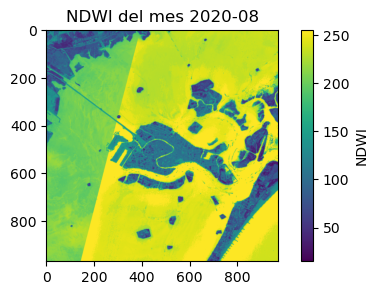

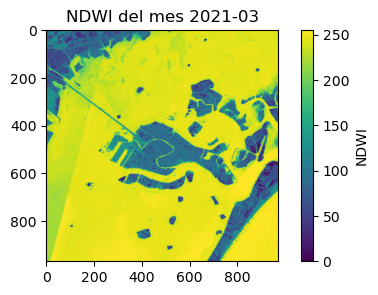

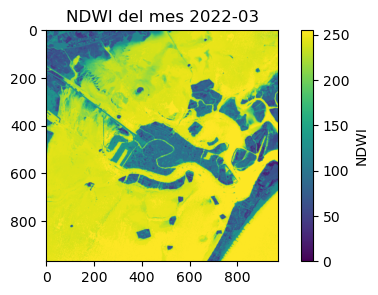

In [91]:
# La lista de imágnes NDWI
ls_ndwi =[]
cont = 0
for ind,(i_t, i_f) in zip(ls_mesaño,zip(ls_tc_2, ls_fc_2)):
    #se calcula para cadda imageb
    i_ndwi = ndwi(i_f,i_t)
    # se almacena
    ls_ndwi.append(i_ndwi)
    # se visualiza
    fig,ax = plt.subplots(1,1,figsize=(6, 3))
    im = ax.imshow(i_ndwi)
    plt.colorbar(im, ax=ax, label='NDWI')
    ax.set_title(f'NDWI del mes {ind}')

## Parte 1 Cálculo de NDTI

El NDTI, Índice térmico de diferencia normalizada, es un indicador de la turbidez del agua, ya que permite ver la opacidad del agua debido a impurezas inorgánicas u orgánicas.
Este índice aprovecha la banda verde y la banda roja, realizando el siguiente cálculo:
$$\text{NDTI} = \frac{\text{Rojo} - \text{Verde}}{\text{Rojo} + \text{Verde}}$$
Este valor queda típicamente entre valores de -1 y 1, la turbidez del agua se encuentra entre valores de 0,4 y 1. La siguiente función realiza el cálculo y  aplica un reesacalado a un rango de valores de 0 a 255 para poder visualizar la imagen.
Resaltar que también tiene su uso en  estudios de las sequia.

In [ ]:

def ndti(img_verdad):
     # Se le pasan dos imágenes, la imagen a verdadero color y a falso color
    # Extraemos la banda roja, que es el primer canal  
    imroj = img_verdad[:,:,0].astype(np.float64)
    # Extraemos la banda  verde,  B03
    imverd = img_verdad[:,:,1].astype(np.float64)
    # Creamos una nueva imagen con valor iniciado -1, para darle luego un valor de 0 en el rescalado a la imagen donde el 
    # divisor sea 0, para las zonas donde no hay agua
    img_res = np.full_like(imverd, -1)
    numer = imroj - imverd
    denom = imroj + imverd
    filtro = denom != 0 
    img_res[filtro] = numer[filtro] / denom[filtro]
    # rescalado de la imagen 
    nvi = ((img_res +1)/2) *255
    return nvi.astype(np.uint8)

A continuación se visualizan las imágenes tras aplicar el índice 

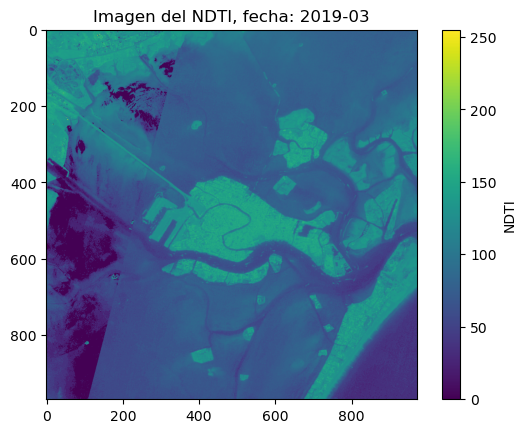

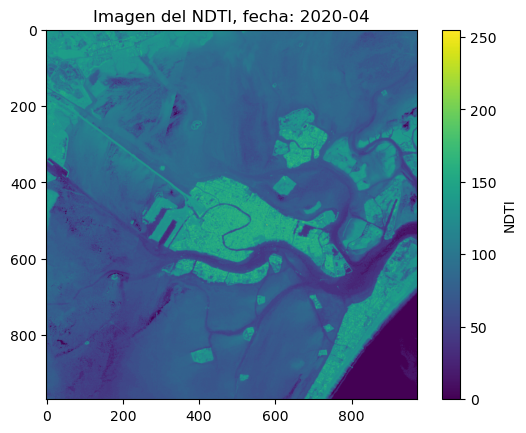

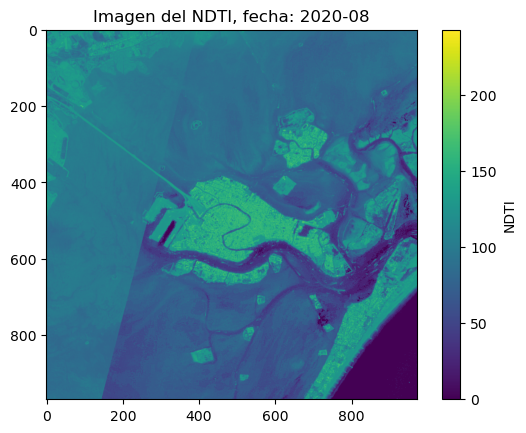

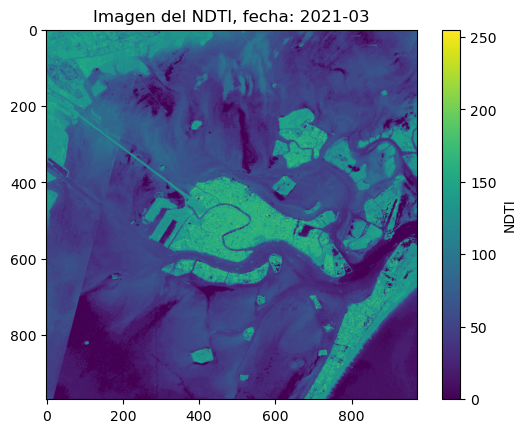

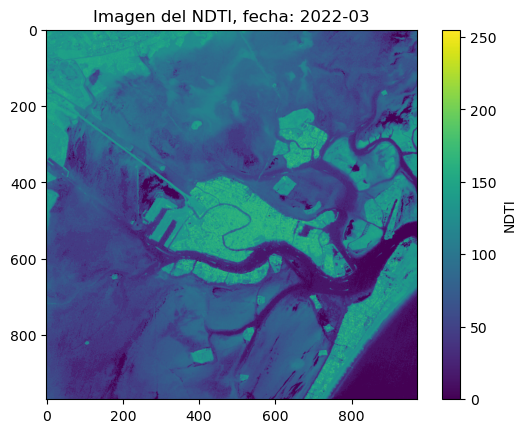

In [93]:
ls_ndti =[]
for ind,i_t in zip(ls_mesaño,ls_tc_2):
    i_ndti = ndti(i_t)
    ls_ndti.append(i_ndti)
    fig,ax = plt.subplots(1,1)
    im = ax.imshow(i_ndti)
    plt.colorbar(im, ax=ax, label='NDTI')
    ax.set_title(f'Imagen del NDTI, fecha: {ind}')

A valores más cercano a 255,es decir a moyor brillo, mayor turbidez

A continuación mediante density slicing, se segmenta el mapa en distintas franjas:
- Azul oscuro: Baja turbidez (alta probabilidad de ser aguas profundas)
- Cian : Poca turbidez.
- Naranja: Turbidez alta.
- Amarillo: Turbidez muy alta.

In [94]:
def densi3(img,umbrales, colores):
    res = np.zeros((img.shape[0],img.shape[1],3)).astype(np.uint8)
    # Aaignación de las zonas donde el incdice es muy bajo
    res[img < umbrales[0] ] = colores[0]
    # Aaignación de las zonas donde el incdice es bajo
    res[(img >= umbrales[0]) & (img < umbrales[1])] = colores[1]
    # Aaignación de las zonas donde el incdice es alto moderado
    res[(img >= umbrales[1]) & (img < umbrales[2])] = colores[2]
    # Aaignación de las zonas donde el incdice es muy alto
    res[img >= umbrales[2] ] = colores[3]
    return res

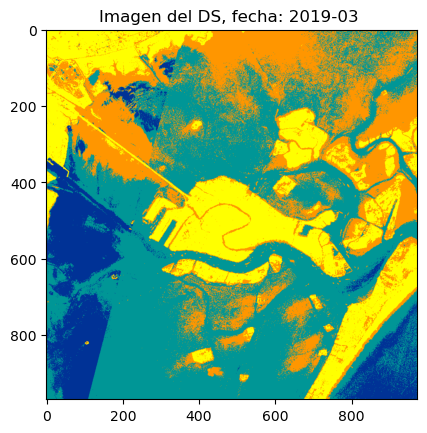

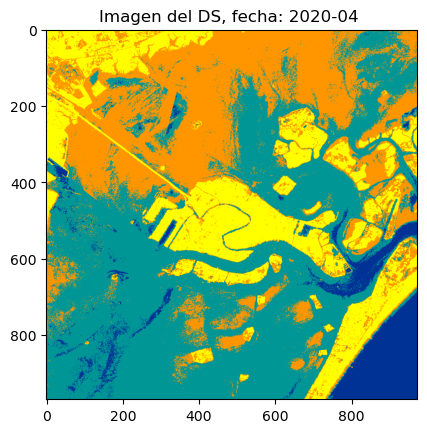

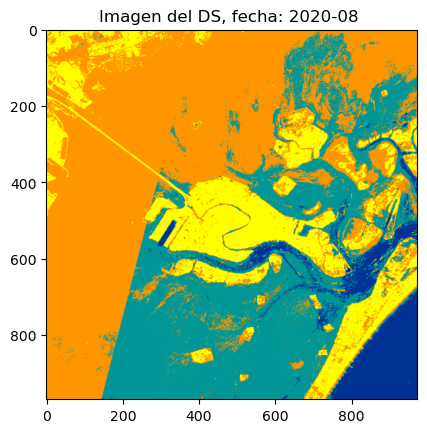

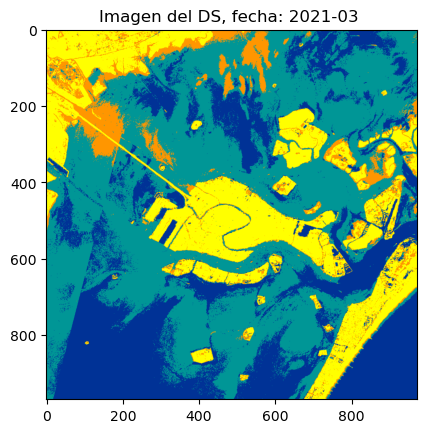

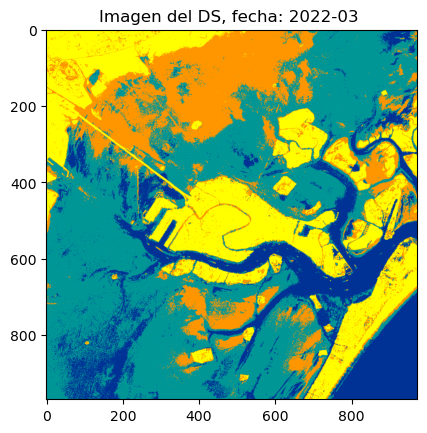

In [95]:

colores = [[0, 50, 150], # Azul oscuro
           [0, 150, 150], # Cian
           [255, 150, 0], # Naranja
           [255, 255, 0]  # Amarillo
          ]
# Usando estos umbrales que dividen los distintos tipos de brillo aproximadamente
umbrales_turbidez = [40, 80, 120]
ls_densi3 = []
for ind,img in zip(ls_mesaño,ls_ndti):
    i_densi3 = densi3(img,umbrales_turbidez,colores)
    ls_densi3.append(i_densi3)
    fig,ax = plt.subplots(1,1)
    ax.imshow(i_densi3)
    ax.set_title(f'Imagen del DS, fecha: {ind} ')

**Observaciones**
- En 2021 después de la pandemia el se presenta en su mayoría zonas con agua de baja turbidez.
- Las zonas de tierra no es de interés.

## Parte 2 NDTI + NDWI

Como solo las zonas de agua son las de interés, estaría bien conminar el índice NDWI con el índice NDTI para determinar laz zonas donde el agua es más turbia y donde es menos turbia.

El siguiente código aplica este enfoque, aplicando las técnicas de density slicing y k-Means y contrastando los resultados

Imágenes de la turbidez del agua


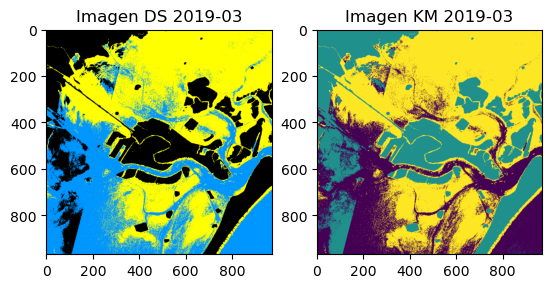

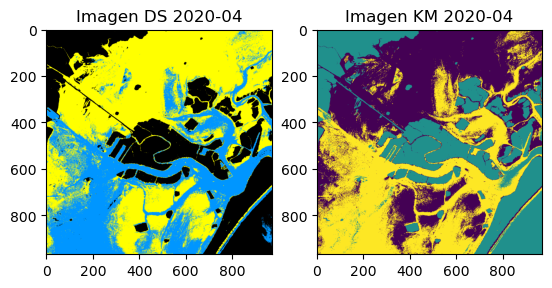

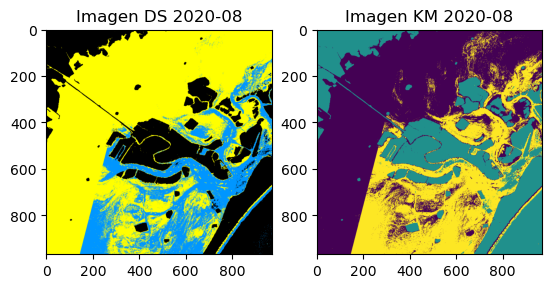

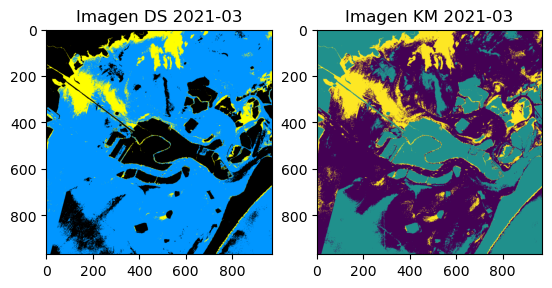

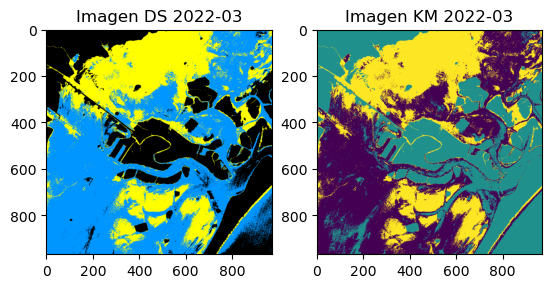

In [96]:
def ndti_ndwi(iw, it, umbral = 160):
    # Si es agua, las zonas donde el indice es > 160
    mask = (iw > umbral)
    # Las zonas donde no haya  agua pasan a ser 0
    mapa_turbi_agua = it * mask
    return mapa_turbi_agua
# se aplica ds para mostrar tres colores distinto, la tierra en negro
# el agua más turbia en amarillo
# el agua menos turbia en azul
def densi4(img,umbral, colores):
    res = np.zeros((img.shape[0],img.shape[1],3)).astype(np.uint8)
    # si vale 0 va al negro
    res[img == 0] = colores[0]
    # si no es tierra y n
    res[(0 < img) & (img< umbral)] = colores[1]
    res[img >= umbral ] = colores[2]
    return res
# función para aplicar kmeans, se visualizan los resultados
def km_aplic(img):
    flat = img.reshape(-1, 1)
    f,c = img.shape
    kmeans = KMeans(
        n_clusters=3, # tres clusters nada más 
        max_iter=100,
        n_init=1,
        random_state=1, 
    ).fit(flat)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    #print(f"Number of elements assigned to each cluster: {cluster_sizes}")
    return kmeans.labels_.reshape(f,c)
    
colores = [[0, 0, 0], # Negro
           [0, 150, 255], # Azul
           [255, 255, 0] # Amarillo
          ]
umbral = 70
ls_turb_w = []
print("Imágenes de la turbidez del agua")
for ind,(imw,imt) in zip(ls_mesaño,zip(ls_ndwi,ls_ndti)):
    i_tw = ndti_ndwi(imw, imt)
    ls_turb_w.append(i_tw)
    i_td3 = densi4(i_tw,umbral,colores)
    i_kmean = km_aplic(i_tw)
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(i_td3)
    ax[0].set_title(f'Imagen DS {ind}')
    ax[1].imshow(i_kmean)
    ax[1].set_title(f'Imagen KM {ind}')
    plt.show()

Para resultados con DS:
- El negro --> Tierra
- El amarillo --> Aguas turbias
- El azul --> Agua claras
  
Para resultados con KM:
- El Cian --> Tierra
- El amarillo --> Aguas turbias
- El morado --> Agua claras

## Conclusiones

- La generación de las imagen mediante un mosaico de varias escenas puede "estropear" un poco los resultados ya que en algunas no se tiene una imagen exacta. Se podría estudiar mejor  la evolución de la turbidez con un conjunto más amplio de imágenes donde se tomen imágenes de unas fechas exactas.
- En 2021, después de la pandemia es cuando más claridad había en el agua.
- En el verano de 2020 es donde más zonas turbias se ven, es importante tener en cuenta que la turbidez no tiene porque ser a causa de suciedad del agua, también se puede dar por otras causas como algas (muy común).
- Se observa que la combinación de los dos índices puede dar lugar a mejores resultados para el estudio.